In [1]:
import os
import numpy as np
import pandas as pd
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import scipy.io as sio
from skimage.transform import resize
from sklearn.preprocessing import MinMaxScaler

import torch
from utils import check_torch, pix2vid_dataset, calculate_metrics
from utils import Units, DualCustomLoss, DualLpLoss, NeuralPix2Vid

In [2]:
NR, NT = 1272, 40
NX, NY = 40, 40
units  = Units()
folder = 'simulations_40x40'
device = check_torch()

------------------------------------------------------------
----------------------- VERSION INFO -----------------------
Torch version: 2.3.1.post300 | Torch Built with CUDA? True
# Device(s) available: 1, Name(s): NVIDIA GeForce RTX 3090
Torch device: cuda
------------------------------------------------------------


In [4]:
tt = np.load('{}/timesteps.npz'.format(folder))
timesteps, deltaTime = tt['timesteps'], tt['deltatime']
t0steps = timesteps[:20]
print('timesteps: {} | deltaT: {}'.format(len(timesteps), np.unique(deltaTime)))

tops2d = sio.loadmat('{}/grids/Gt.mat'.format(folder), simplify_cells=True)['Gt']['cells']['z'].reshape(NX,NY,order='F')
print('tops2d: {}'.format(tops2d.shape))

timesteps: 40 | deltaT: [  0.5 250. ]
tops2d: (40, 40)


In [5]:
(Xt, ct, y1t, y2t, all_volumes, idx), (trainloader, validloader) = pix2vid_dataset(folder='simulations_40x40',
                                                                                   batch_size=32,
                                                                                   send_to_device=True,
                                                                                   device=device)

X: (1272, 4, 40, 40) | c: (1272, 20, 5) | y1: (1272, 20, 2, 40, 40) | y2: (1272, 20, 1, 40, 40)
----------------------------------------------------------------------------------------------------
Train - X:  torch.Size([1000, 4, 40, 40])     | c:  torch.Size([1000, 20, 5])
        y1: torch.Size([1000, 20, 2, 40, 40]) | y2: torch.Size([1000, 20, 1, 40, 40])
--------------------
Valid - X:  torch.Size([136, 4, 40, 40])     | c:  torch.Size([136, 20, 5])
        y1: torch.Size([136, 20, 2, 40, 40]) | y2: torch.Size([136, 20, 1, 40, 40])
--------------------
Test  - X:  torch.Size([136, 4, 40, 40])     | c:  torch.Size([136, 20, 5])
        y1: torch.Size([136, 20, 2, 40, 40]) | y2: torch.Size([136, 20, 1, 40, 40])


In [8]:
model = NeuralPix2Vid(device=device).to(device)
model.load_state_dict(torch.load('neural-pix2vid_model.pth'))

nparams = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('# parameters: {:,} | device: {}'.format(nparams, model.device))

# parameters: 4,261,815 | device: cuda


In [9]:
tempxt = Xt[:20]
tempct = ct[:20]
print('Xt: {} | ct: {}'.format(tempxt.shape, tempct.shape))

tempy1t = y1t[:20]
tempy2t = y2t[:20]
print('y1t: {} | y2t: {}'.format(tempy1t.shape, tempy2t.shape))

Xt: torch.Size([20, 4, 40, 40]) | ct: torch.Size([20, 20, 5])
y1t: torch.Size([20, 20, 2, 40, 40]) | y2t: torch.Size([20, 20, 1, 40, 40])


In [10]:
tempx = Xt[:20].detach().cpu().numpy()
tempc = ct[:20].detach().cpu().numpy()
print('Xt: {} | ct: {}'.format(tempx.shape, tempc.shape))

tempy1 = y1t[:20].detach().cpu().numpy()
tempy2 = y2t[:20].detach().cpu().numpy()
print('y1t: {} | y2t: {}'.format(tempy1.shape, tempy2.shape))

Xt: (20, 4, 40, 40) | ct: (20, 20, 5)
y1t: (20, 20, 2, 40, 40) | y2t: (20, 20, 1, 40, 40)


In [11]:
tempy1p, temp2yp = model(tempxt, tempct)
tempy1p, tempy2p = tempy1p.detach().cpu().numpy(), temp2yp.detach().cpu().numpy()
print('y1p: {} | y2p: {}'.format(tempy1p.shape, temp2yp.shape))

y1p: (20, 20, 2, 40, 40) | y2p: torch.Size([20, 20, 1, 40, 40])


In [12]:
calculate_metrics(tempy1, tempy2, tempy1p, tempy2p)

---------------------------------------------------------------------------------
------------------------------------ METRICS ------------------------------------
---------------------------------------------------------------------------------
R2   - pressure: -7.1225 | saturation (inj): -inf | saturation (monitor): -83715836827668327179409686528.0000
MSE  - pressure: 0.1017 | saturation (inj): 0.0583 | saturation (monitor): 0.0853
SSIM - pressure: 0.0215 | saturation (inj): 0.0553 | saturation (monitor): 0.0153
PSNR - pressure: 9.9279 | saturation (inj): 12.3454 | saturation (monitor): 10.6897
---------------------------------------------------------------------------------


/home/misaelmorales/miniconda3/envs/rapid/lib/python3.11/site-packages/sklearn/metrics/_regression.py:886: RuntimeWarning: overflow encountered in divide
  numerator[valid_score] / denominator[valid_score]


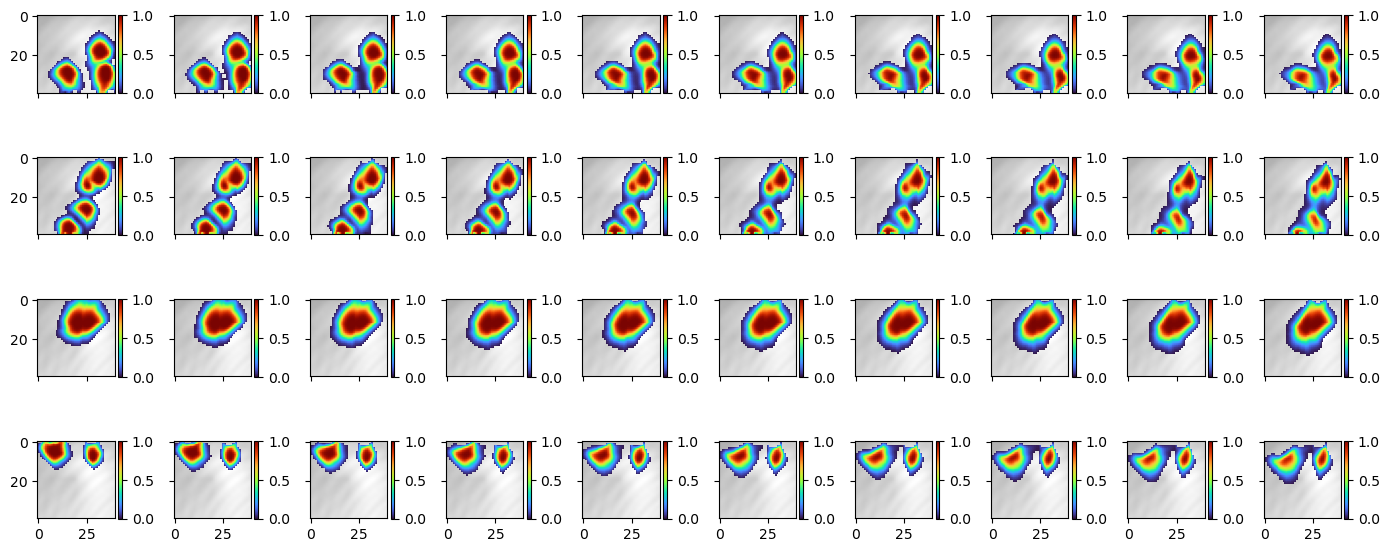

In [13]:
fig, axs = plt.subplots(4, 10, figsize=(14,6), sharex=True, sharey=True)
for i in range(4):
    for j in range(10):
        k = j*2+1
        ax = axs[i,j]
        d = np.ma.masked_where(tempy2[i,k,-1]<0.01, tempy2[i,k,-1])
        ax.imshow(tops2d, cmap='binary', alpha=0.33)
        im = ax.imshow(d, cmap='turbo', vmin=0, vmax=1)
        plt.colorbar(im, pad=0.04, fraction=0.046)
plt.tight_layout()
plt.show()

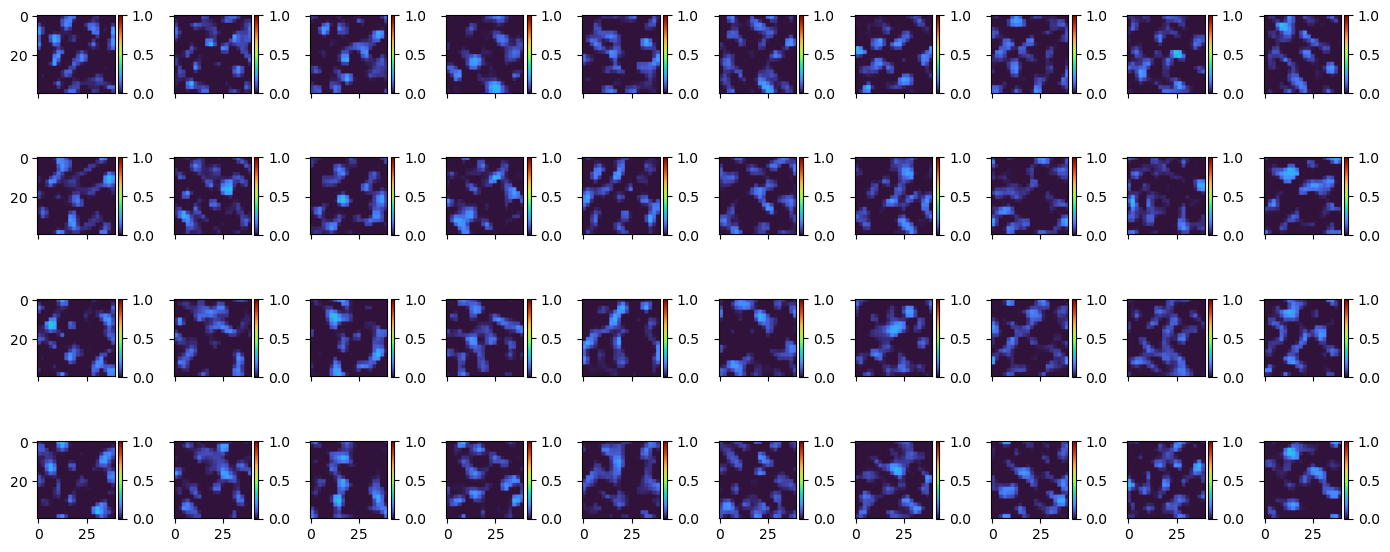

In [15]:
fig, axs = plt.subplots(4, 10, figsize=(14,6), sharex=True, sharey=True)
for i in range(4):
    for j in range(10):
        k = j*2+1
        ax = axs[i,j]
        #d = np.ma.masked_where(tempy2p[i,k,-1]<0.01, tempy2[i,k,-1])
        d = tempy2p[i,k,-1]
        ax.imshow(tops2d, cmap='binary', alpha=0.33)
        im = ax.imshow(d, cmap='turbo', vmin=0, vmax=1)
        plt.colorbar(im, pad=0.04, fraction=0.046)
plt.tight_layout()
plt.show()

***
# END